In [3]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from keras.layers import concatenate, BatchNormalization, Input
from keras.layers.merge import add
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import plot_model

import matplotlib.pyplot as plt
import cv2
import string
import time

In [4]:
token_path = 'Flickr8k.token.txt'
text = open(token_path, 'r', encoding = 'utf-8').read()
print(text[:500])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7


In [5]:
def load_description(text):
    mapping = dict()
    for line in text.split("\n"):
        token = line.split("\t")
        if len(line) < 2:
            continue
        img_id = token[0].split('.')[0]
        img_des = token[1]
        if img_id not in mapping:
            mapping[img_id] = list()
        mapping[img_id].append(img_des)
    return mapping

descriptions = load_description(text)
print("Number of items: " + str(len(descriptions)),'\n')
print("Items: ",descriptions)

Number of items: 8092 

Items:  {'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .'], '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .'], '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There

In [6]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [7]:
def clean_description(desc):
    for key, des_list in desc.items():
        for i in range(len(des_list)):
            caption = des_list[i]
            caption = [ch for ch in caption if ch not in string.punctuation]
            caption = ''.join(caption)
            caption = caption.split(' ')
            caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()]
            caption = ' '.join(caption)
            des_list[i] = caption

clean_description(descriptions)
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [8]:
def to_vocab(desc):
    words = set()
    for key in desc.keys():
        for line in desc[key]:
            words.update(line.split())
    return words
vocab = to_vocab(descriptions)
len(vocab)

8763

In [9]:
vocab

{'clean',
 'deck',
 'dappled',
 'notebook',
 'blackrobed',
 'strung',
 'swingset',
 'clipped',
 'heavyset',
 'quarters',
 'night',
 'huddles',
 'parasailors',
 'sari',
 'question',
 'lush',
 'glancing',
 'exercising',
 'gingerbread',
 'sparks',
 'inflatable',
 'skirt',
 'say',
 'throws',
 'dj',
 'nubby',
 'member',
 'allmale',
 'startled',
 'shooting',
 'lip',
 'halter',
 'tight',
 'body',
 'cricket',
 'strapped',
 'handheld',
 'organic',
 'angel',
 'sifting',
 'outlines',
 'caches',
 'shorthaired',
 'streamers',
 'recieving',
 'dunking',
 'campus',
 'headline',
 'badly',
 'clap',
 'fountain',
 'stocking',
 'terminal',
 'bum',
 'signature',
 'carving',
 'butting',
 'curb',
 'expanse',
 'messily',
 'squated',
 'backs',
 'bloody',
 'chestnut',
 'wheat',
 'dirtcovered',
 'minivan',
 'peek',
 'bikinis',
 'reddishbrown',
 'multipiercings',
 'hoes',
 'peeking',
 'glowing',
 'nt',
 'meet',
 'heron',
 'pants',
 'tribal',
 'saucers',
 'frisbeen',
 'birds',
 'snowballs',
 'carrier',
 'mr',
 'bra

In [10]:
import glob
images = 'Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')
len(img)

8091

In [11]:
img

['Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 'Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 'Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 'Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 'Flicker8k_Dataset\\1007129816_e794419615.jpg',
 'Flicker8k_Dataset\\1007320043_627395c3d8.jpg',
 'Flicker8k_Dataset\\1009434119_febe49276a.jpg',
 'Flicker8k_Dataset\\1012212859_01547e3f17.jpg',
 'Flicker8k_Dataset\\1015118661_980735411b.jpg',
 'Flicker8k_Dataset\\1015584366_dfcec3c85a.jpg',
 'Flicker8k_Dataset\\101654506_8eb26cfb60.jpg',
 'Flicker8k_Dataset\\101669240_b2d3e7f17b.jpg',
 'Flicker8k_Dataset\\1016887272_03199f49c4.jpg',
 'Flicker8k_Dataset\\1019077836_6fc9b15408.jpg',
 'Flicker8k_Dataset\\1019604187_d087bf9a5f.jpg',
 'Flicker8k_Dataset\\1020651753_06077ec457.jpg',
 'Flicker8k_Dataset\\1022454332_6af2c1449a.jpg',
 'Flicker8k_Dataset\\1022454428_b6b660a67b.jpg',
 'Flicker8k_Dataset\\1022975728_75515238d8.jpg',
 'Flicker8k_Dataset\\102351840_323e3de834.jpg',
 'Flicker8k_Dataset\\10

In [12]:
train_path = 'Flickr_8k.trainImages.txt'
train_images = open(train_path, 'r', encoding = 'utf-8').read().split("\n")
train_img = []

for im in img:
    if(im[len(images):] in train_images):
        train_img.append(im)
        
len(train_img)

6000

In [13]:
test_path = 'Flickr_8k.testImages.txt'
test_images = open(test_path, 'r', encoding = 'utf-8').read().split("\n")
test_img = []

for im in img:
    if(im[len(images): ] in test_images):
        test_img.append(im)
len(test_img)

1000

In [14]:
def load_clean_descriptions(des, dataset):
    dataset_des = dict()
    for key, des_list in des.items():
        if key+'.jpg' in dataset:
            if key not in dataset_des:
                dataset_des[key] = list()
            for line in des_list:
                desc = 'startseq ' + line + ' endseq'
                dataset_des[key].append(desc)
    return dataset_des

train_descriptions = load_clean_descriptions(descriptions, train_images)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [36]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [37]:
base_model = VGG16(weights = 'imagenet')
base_model.summary()

553467904/553467096 [==============================] - 239s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

In [38]:
def preprocess_img(img_path):
    #vgg16 excepts img in 224*224
    img = load_img(img_path, target_size = (224, 224))
    x = img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)
    return x

In [39]:
model = Model(base_model.input, base_model.layers[-2].output)

In [40]:
def encode(image):
    image = preprocess_img(image)
    vec = model.predict(image)
    vec = np.reshape(vec, (vec.shape[1]))
    return vec

In [43]:
start = time.time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time Taken is: " + str(time.time() - start))

Time Taken is: 2179.5726642608643


In [44]:
start = time.time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken is: " + str(time.time() - start))

Time taken is: 417.8018968105316


In [45]:
train_features = encoding_train
test_features = encoding_test
print("Train image encodings: " + str(len(train_features)))
print("Test image encodings: " + str(len(test_features)))

Train image encodings: 6000
Test image encodings: 1000


In [46]:
train_features

{'1000268201_693b08cb0e.jpg': array([2.5076473, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ], dtype=float32),
 '1001773457_577c3a7d70.jpg': array([0.        , 0.        , 0.49410743, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 '1002674143_1b742ab4b8.jpg': array([1.4937081, 0.       , 0.5356841, ..., 2.315414 , 3.7418418,
        0.       ], dtype=float32),
 '1003163366_44323f5815.jpg': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 '1007129816_e794419615.jpg': array([0.        , 0.09227565, 0.        , ..., 0.        , 0.        ,
        0.06529307], dtype=float32),
 '1007320043_627395c3d8.jpg': array([0.       , 0.       , 0.       , ..., 0.       , 3.3386436,
        0.       ], dtype=float32),
 '1009434119_febe49276a.jpg': array([2.096293  , 2.1193194 , 3.562437  , ..., 0.64264107, 2.7146509 ,
        0.        ], dtype=float32),
 '1012212859_01547e3f17.jpg': array([0.       , 0.       , 0.9873714, ..., 0.       , 1.4932494,
    

In [47]:
train_features['1000268201_693b08cb0e.jpg'].shape

(4096,)

In [15]:
all_train_captions = []
for key, val in train_descriptions.items():
    for caption in val:
        all_train_captions.append(caption)
len(all_train_captions)

30000

In [16]:
all_train_captions

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas w

In [17]:
vocabulary = vocab
threshold = 10
word_counts = {}
for cap in all_train_captions:
    for word in cap.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold]
print("Unique words: " + str(len(word_counts)))
print("our Vocabulary: " + str(len(vocab)))

Unique words: 7578
our Vocabulary: 1651


In [18]:
word_counts

{'startseq': 30000,
 'child': 1120,
 'in': 14085,
 'pink': 543,
 'dress': 260,
 'is': 6907,
 'climbing': 375,
 'up': 903,
 'set': 81,
 'of': 4967,
 'stairs': 81,
 'an': 1807,
 'entry': 1,
 'way': 41,
 'endseq': 30000,
 'girl': 2414,
 'going': 111,
 'into': 757,
 'wooden': 209,
 'building': 373,
 'little': 1266,
 'playhouse': 6,
 'the': 13509,
 'to': 2303,
 'her': 861,
 'cabin': 3,
 'black': 2854,
 'dog': 6159,
 'and': 6672,
 'spotted': 27,
 'are': 2619,
 'fighting': 97,
 'tricolored': 10,
 'playing': 1486,
 'with': 5763,
 'each': 318,
 'other': 567,
 'on': 8006,
 'road': 305,
 'white': 2921,
 'brown': 1995,
 'spots': 22,
 'staring': 43,
 'at': 2101,
 'street': 703,
 'two': 4246,
 'dogs': 1620,
 'different': 28,
 'breeds': 5,
 'looking': 563,
 'pavement': 39,
 'moving': 27,
 'toward': 109,
 'covered': 229,
 'paint': 44,
 'sits': 437,
 'front': 996,
 'painted': 50,
 'rainbow': 18,
 'hands': 180,
 'bowl': 21,
 'sitting': 1018,
 'large': 894,
 'small': 940,
 'grass': 1222,
 'plays': 392,
 

In [19]:
vocab

['startseq',
 'child',
 'in',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'set',
 'of',
 'stairs',
 'an',
 'way',
 'endseq',
 'girl',
 'going',
 'into',
 'wooden',
 'building',
 'little',
 'the',
 'to',
 'her',
 'black',
 'dog',
 'and',
 'spotted',
 'are',
 'fighting',
 'tricolored',
 'playing',
 'with',
 'each',
 'other',
 'on',
 'road',
 'white',
 'brown',
 'spots',
 'staring',
 'at',
 'street',
 'two',
 'dogs',
 'different',
 'looking',
 'pavement',
 'moving',
 'toward',
 'covered',
 'paint',
 'sits',
 'front',
 'painted',
 'rainbow',
 'hands',
 'bowl',
 'sitting',
 'large',
 'small',
 'grass',
 'plays',
 'it',
 'there',
 'pigtails',
 'painting',
 'young',
 'outside',
 'man',
 'lays',
 'bench',
 'while',
 'his',
 'by',
 'him',
 'which',
 'also',
 'tied',
 'sleeping',
 'next',
 'shirtless',
 'lies',
 'park',
 'laying',
 'holding',
 'leash',
 'ground',
 'orange',
 'hat',
 'something',
 'wears',
 'glasses',
 'wearing',
 'beer',
 'can',
 'ears',
 'rope',
 'net',
 'red',
 'climbs',
 '

In [20]:
ixtoword = {}
wordtoix = {}

ix = 1
for word in vocab:
    wordtoix[word] = ix
    ixtoword[ix] = word
    ix += 1

In [21]:
wordtoix

{'startseq': 1,
 'child': 2,
 'in': 3,
 'pink': 4,
 'dress': 5,
 'is': 6,
 'climbing': 7,
 'up': 8,
 'set': 9,
 'of': 10,
 'stairs': 11,
 'an': 12,
 'way': 13,
 'endseq': 14,
 'girl': 15,
 'going': 16,
 'into': 17,
 'wooden': 18,
 'building': 19,
 'little': 20,
 'the': 21,
 'to': 22,
 'her': 23,
 'black': 24,
 'dog': 25,
 'and': 26,
 'spotted': 27,
 'are': 28,
 'fighting': 29,
 'tricolored': 30,
 'playing': 31,
 'with': 32,
 'each': 33,
 'other': 34,
 'on': 35,
 'road': 36,
 'white': 37,
 'brown': 38,
 'spots': 39,
 'staring': 40,
 'at': 41,
 'street': 42,
 'two': 43,
 'dogs': 44,
 'different': 45,
 'looking': 46,
 'pavement': 47,
 'moving': 48,
 'toward': 49,
 'covered': 50,
 'paint': 51,
 'sits': 52,
 'front': 53,
 'painted': 54,
 'rainbow': 55,
 'hands': 56,
 'bowl': 57,
 'sitting': 58,
 'large': 59,
 'small': 60,
 'grass': 61,
 'plays': 62,
 'it': 63,
 'there': 64,
 'pigtails': 65,
 'painting': 66,
 'young': 67,
 'outside': 68,
 'man': 69,
 'lays': 70,
 'bench': 71,
 'while': 72,
 

In [22]:
ixtoword

{1: 'startseq',
 2: 'child',
 3: 'in',
 4: 'pink',
 5: 'dress',
 6: 'is',
 7: 'climbing',
 8: 'up',
 9: 'set',
 10: 'of',
 11: 'stairs',
 12: 'an',
 13: 'way',
 14: 'endseq',
 15: 'girl',
 16: 'going',
 17: 'into',
 18: 'wooden',
 19: 'building',
 20: 'little',
 21: 'the',
 22: 'to',
 23: 'her',
 24: 'black',
 25: 'dog',
 26: 'and',
 27: 'spotted',
 28: 'are',
 29: 'fighting',
 30: 'tricolored',
 31: 'playing',
 32: 'with',
 33: 'each',
 34: 'other',
 35: 'on',
 36: 'road',
 37: 'white',
 38: 'brown',
 39: 'spots',
 40: 'staring',
 41: 'at',
 42: 'street',
 43: 'two',
 44: 'dogs',
 45: 'different',
 46: 'looking',
 47: 'pavement',
 48: 'moving',
 49: 'toward',
 50: 'covered',
 51: 'paint',
 52: 'sits',
 53: 'front',
 54: 'painted',
 55: 'rainbow',
 56: 'hands',
 57: 'bowl',
 58: 'sitting',
 59: 'large',
 60: 'small',
 61: 'grass',
 62: 'plays',
 63: 'it',
 64: 'there',
 65: 'pigtails',
 66: 'painting',
 67: 'young',
 68: 'outside',
 69: 'man',
 70: 'lays',
 71: 'bench',
 72: 'while',
 

In [24]:
try: 
    file = open('wordtoix.txt', 'wt') 
    file.write(str(wordtoix)) 
    file.close() 
  
except: 
    print("Unable to write to file")

In [25]:
try: 
    file = open('ixtoword.txt', 'wt') 
    file.write(str(ixtoword)) 
    file.close() 
  
except: 
    print("Unable to write to file")

In [54]:
vocab_size = len(ixtoword) + 1  #1 for appended zeros
vocab_size

1652

In [55]:
max_length = max(len(des.split()) for des in all_train_captions)
max_length

34

In [56]:
X1, X2, y = list(), list(), list()
for key, des_list in train_descriptions.items():
    pic = train_features[key + '.jpg']
    for cap in des_list:
        seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            #store
            X1.append(pic)
            X2.append(in_seq)
            y.append(out_seq)

X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)
print(X1.shape)

(292328, 4096)


In [65]:
# define the model
ip1 = Input(shape = (4096, ))
fe1 = Dropout(0.2)(ip1)
fe2 = Dense(256, activation = 'relu')(fe1)
ip2 = Input(shape = (max_length, ))
se1 = Embedding(vocab_size, 200, mask_zero = True)(ip2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
model = Model(inputs = [ip1, ip2], outputs = outputs)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_7[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 4096)         0           input_6[0][0]                    
_______________________________________________________________________________________

In [60]:
#load glove vectors for embedding layer
embeddings_index = {}
glove = open('glove.6B.200d.txt', 'r', encoding = 'utf-8').read()
for line in glove.split("\n"):
    values = line.split(" ")
    word = values[0]
    indices = np.asarray(values[1: ], dtype = 'float32')
    embeddings_index[word] = indices
print('Total word vectors: ' + str(len(embeddings_index)))

Total word vectors: 400001


In [61]:
emb_dim = 200
emb_matrix = np.zeros((vocab_size, emb_dim))
for word, i in wordtoix.items():
    emb_vec = embeddings_index.get(word)
    if emb_vec is not None:
        emb_matrix[i] = emb_vec
emb_matrix.shape

(1652, 200)

In [66]:
model.layers[2].set_weights([emb_matrix])
model.layers[2].trainable = False
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [67]:
for i in range(10):
    model.fit([X1, X2], y, epochs = 1, batch_size = 256)
    if(i%2 == 0):
        model.save_weights("image-caption-weights" + str(i) + ".h5")

1142/1142 [==============================] - 614s 537ms/step - loss: 2.2824


In [68]:
def greedy_search(pic):
    start = 'startseq'
    for i in range(max_length):
        seq = [wordtoix[word] for word in start.split() if word in wordtoix]
        seq = pad_sequences([seq], maxlen = max_length)
        yhat = model.predict([pic, seq])
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        start += ' ' + word
        if word == 'endseq':
            break
    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

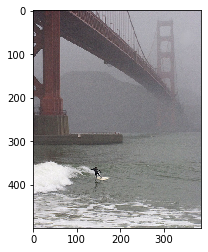

person in black and white striped shirt is standing on the edge of dock


In [72]:
pic = list(encoding_test.keys())[169]
img = encoding_test[pic].reshape(1, 4096)
x = plt.imread(images + pic)
plt.imshow(x)
plt.show()
print(greedy_search(img))

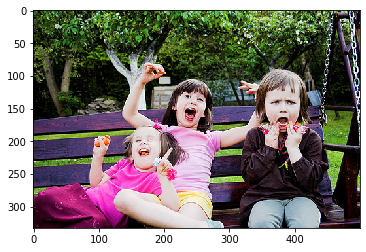

two girls are dancing on trampoline


In [73]:
pic = list(encoding_test.keys())[269]
img = encoding_test[pic].reshape(1, 4096)
x = plt.imread(images + pic)
plt.imshow(x)
plt.show()
print(greedy_search(img))

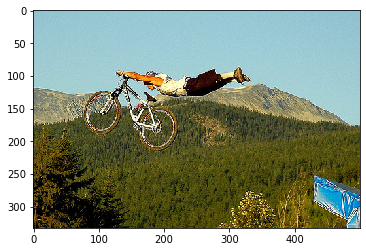

person is riding green atv


In [74]:
pic = list(encoding_test.keys())[369]
img = encoding_test[pic].reshape(1, 4096)
x = plt.imread(images + pic)
plt.imshow(x)
plt.show()
print(greedy_search(img))

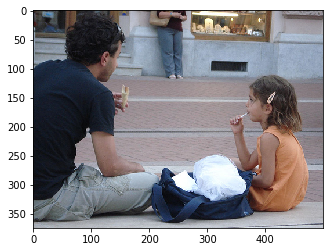

woman and baby sit on the floor


In [76]:
pic = list(encoding_test.keys())[100]
img = encoding_test[pic].reshape(1, 4096)
x = plt.imread(images + pic)
plt.imshow(x)
plt.show()
print(greedy_search(img))